# SetFit Model Optimization with Intel Extension for Transformers

## Setup Development Environment

In [ ]:
!pip install intel-extension-for-transformers neural-compressor==1.14.2 setfit datasets torch wandb matplotlib onnx onnxruntime

## SetFit Models on AG News Dataset

In [2]:
import numpy as np
import torch
from datasets import load_metric
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation, util
from time import perf_counter

/home2/xinyuye/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [3]:
from datasets import load_dataset
agnews = load_dataset("ag_news")
test_dataset = agnews["test"]
topics = agnews["test"].features["label"]

Found cached dataset ag_news (/home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 554.51it/s]


### Creating a Performance Benchmark

In [4]:
accuracy_score = load_metric("accuracy")

class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self):
        latencies = []
        # Warmup
        for i in range(10):
            _ = self.model([self.dataset["text"][i]])
        # Timed run
        for i in range(100):
            start_time = perf_counter()
            _ = self.model([self.dataset["text"][i]])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

/tmp/ipykernel_262654/542924604.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


### Train MPNet - The teacher model

In [5]:
num_classes = 4
train_dataset = agnews["train"].shuffle(seed=0).select(range(8 * num_classes))

Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow


In [6]:
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Load a SetFit model from Hub
model_id = "paraphrase-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

# Create trainer
teacher_trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
)

# Train and evaluate
teacher_trainer.train()
metrics = teacher_trainer.evaluate()

print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {metrics['accuracy']}")

MPNet_teacher_model = teacher_trainer.model.model_body

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16
Iteration:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 68/80 [01:10<00:12,  1.03s/it]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:22<00:00, 82.69s/it]
***** Running evaluation *****


model used: paraphrase-mpnet-base-v2
train dataset: 32 samples
accuracy: 0.8506578947368421


In [7]:
optim_type = "MPNet_teacher FP32 Torch"
pb = PerformanceBenchmark(
    model=teacher_trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics = pb.run_benchmark()

Model size (MB) - 417.73
Accuracy on test set - 0.851
Average latency (ms) - 37.20 +\- 4.12


### Train mini_LM_L3 - The student model

In [8]:
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss

# Load a SetFit model from Hub
model_id = 'paraphrase-MiniLM-L3-v2'
model = SetFitModel.from_pretrained(model_id)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

print(f"model used: {model_id}")
print(f"train dataset: {len(train_dataset)} samples")
print(f"accuracy: {metrics['accuracy']}")

MiniLM_L3_model = trainer.model.model_body

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16
Iteration:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 68/80 [00:10<00:01,  6.28it/s]


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.74s/it]
***** Running evaluation *****


model used: paraphrase-MiniLM-L3-v2
train dataset: 32 samples
accuracy: 0.7147368421052631


In [9]:
optim_type = "MiniLM_L3_student FP32 Torch"
pb = PerformanceBenchmark(
    model=trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 66.36
Accuracy on test set - 0.715
Average latency (ms) - 13.38 +\- 0.84


### SetFit distillation on the student model 

In [10]:
from setfit import SetFitModel, SetFitTrainer, DistillationSetFitTrainer

train_dataset_student = agnews["train"].shuffle(seed=0).select(range(1000))

#Distill
student_model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L3-v2")
teacher_model = teacher_trainer.model
student_trainer = DistillationSetFitTrainer(teacher_model=teacher_model, train_dataset=train_dataset_student, student_model=student_model, eval_dataset=test_dataset, loss_class=CosineSimilarityLoss, metric="accuracy", batch_size=16, num_iterations=20, num_epochs=1)

# Student Train and evaluate
student_trainer.train()
metrics = student_trainer.evaluate()
print("Student results: ", metrics)
MiniLM_L3_distilled_model = student_trainer.model.model_body
MiniLM_L3_distilled_model.save('MiniLM_L3_distilled')

Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 40000
  Num epochs = 1
  Total optimization steps = 2500
  Total train batch size = 16
Iteration:   3%|████▋                                                                                                                                                                        | 67/2500 [00:12<07:21,  5.51it/s]


Iteration:   6%|█████████▌                                                                                                                                                                  | 139/2500 [00:25<07:09,  5.50it/s]


Iteration:   8%|██████████████▌                                                                                                                                                             | 211/2500 [00:38<06:53,  5.54it/s]


Iteration:  11%|███████████████████▍                                                                                                                                                        | 283/2500 [00:51<06:48,  5.42it/s]


Iteration:  14%|████████████████████████▍                                                                                                                                                   | 355/2500 [01:04<06:33,  5.44it/s]


Iteration:  17%|█████████████████████████████▍                                                                                                                                              | 427/2500 [01:17<06:10,  5.59it/s]


Iteration:  20%|██████████████████████████████████▎                                                                                                                                         | 499/2500 [01:30<06:10,  5.41it/s]


Iteration:  23%|███████████████████████████████████████▎                                                                                                                                    | 571/2500 [01:44<05:51,  5.49it/s]


Iteration:  26%|████████████████████████████████████████████▏                                                                                                                               | 643/2500 [01:57<05:45,  5.38it/s]


Iteration:  29%|█████████████████████████████████████████████████▏                                                                                                                          | 715/2500 [02:10<05:28,  5.43it/s]


Iteration:  31%|██████████████████████████████████████████████████████▏                                                                                                                     | 787/2500 [02:24<05:23,  5.30it/s]


Iteration:  34%|███████████████████████████████████████████████████████████                                                                                                                 | 859/2500 [02:37<05:01,  5.44it/s]


Iteration:  37%|████████████████████████████████████████████████████████████████                                                                                                            | 931/2500 [02:51<04:48,  5.43it/s]


Iteration:  40%|████████████████████████████████████████████████████████████████████▌                                                                                                      | 1003/2500 [03:04<04:34,  5.45it/s]


Iteration:  43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1075/2500 [03:17<04:16,  5.56it/s]


Iteration:  46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1147/2500 [03:30<04:01,  5.60it/s]


Iteration:  49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1219/2500 [03:43<04:01,  5.31it/s]


Iteration:  52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1291/2500 [03:56<03:38,  5.53it/s]


Iteration:  55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1363/2500 [04:09<03:31,  5.38it/s]


Iteration:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1435/2500 [04:23<03:17,  5.39it/s]


Iteration:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1507/2500 [04:36<03:00,  5.51it/s]


Iteration:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1579/2500 [04:49<02:48,  5.48it/s]


Iteration:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1651/2500 [05:02<02:34,  5.51it/s]


Iteration:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1723/2500 [05:16<02:27,  5.28it/s]


Iteration:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1795/2500 [05:29<02:08,  5.49it/s]


Iteration:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1867/2500 [05:42<01:54,  5.51it/s]


Iteration:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1939/2500 [05:55<01:42,  5.49it/s]


Iteration:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2011/2500 [06:08<01:28,  5.54it/s]


Iteration:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2083/2500 [06:21<01:16,  5.45it/s]


Iteration:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2155/2500 [06:34<01:03,  5.46it/s]


Iteration:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2227/2500 [06:48<00:51,  5.30it/s]


Iteration:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2299/2500 [07:01<00:37,  5.33it/s]


Iteration:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2371/2500 [07:15<00:23,  5.51it/s]


Iteration:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2443/2500 [07:28<00:10,  5.45it/s]


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [07:38<00:00, 458.85s/it]
***** Running evaluation *****


Student results:  {'accuracy': 0.8464473684210526}


In [11]:
optim_type = "MiniLM_L3_student_distilled FP32 Torch"
pb = PerformanceBenchmark(
    model=student_trainer.model, dataset=test_dataset, optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 66.36
Accuracy on test set - 0.846
Average latency (ms) - 13.13 +\- 0.88


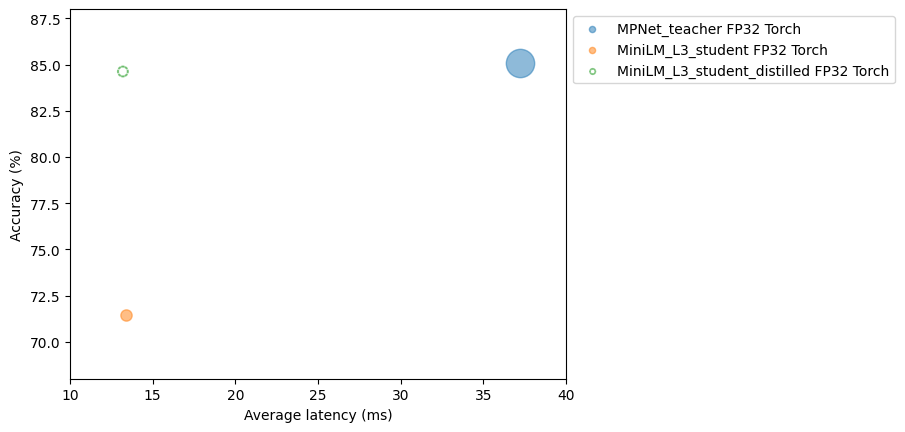

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    ys = [perf_metrics[k]["accuracy"]*100 for k in perf_metrics]
    plt.ylim(int(min(ys) - 3), int(max(ys) + 3))
    xs = [perf_metrics[k]["time_avg_ms"] for k in perf_metrics]
    plt.xlim(int(min(xs) - 3), int(max(xs) + 3))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

## Optimizing SetFit Model with Intel Extension for Transformers

### Quantize the SetFit model and convert to ONNX

In [13]:
from intel_extension_for_transformers.optimization.config import QuantizationConfig
from intel_extension_for_transformers.optimization.utils import metrics, objectives
from intel_extension_for_transformers.optimization.trainer import NLPTrainer
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    default_data_collator,
    set_seed,
)

raw_datasets = load_dataset("ag_news")
model_id = "MiniLM_L3_distilled"

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state'] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9, max=1e9)

class SetFitModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        if hasattr(model, 'config'):
            self.config = model.config
    
    def forward(self, input_ids, attention_mask, token_type_ids=None, *args, **kwargs):
        if token_type_ids is not None:
            model_output = self.model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        else:
            model_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask)
        return sentence_embeddings

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

def preprocess_function(examples):
    # Tokenize the texts
    args = ((examples["text"],))
    result = tokenizer(*args, padding="max_length", max_length=128, truncation=True)
    result["label"] = examples["label"]
    return result

def compute_metrics(preds, labels):
    return (preds == labels).astype(np.float32).mean().item()

num_classes = 4
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=0).select(range(8 * num_classes))
preprocessed_datasets = raw_datasets.map(preprocess_function, batched=True)
preprocessed_datasets = preprocessed_datasets.remove_columns(['text', ])

train_dataset = preprocessed_datasets["train"]
eval_dataset = preprocessed_datasets["test"]

def eval_func(model):
    setfit_model = SetFitModel(model)
    def get_data(model, dataloader):
        embeddings = []
        labels = []
        for model_input in tqdm(dataloader):
            labels.append(model_input.pop('labels').numpy())
            embedding = model(**model_input)
            embedding = embedding.detach().cpu().numpy()
            embeddings.append(embedding)
        return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)
    # train logistic regressor
    embeddings, labels = get_data(setfit_model, trainer.get_train_dataloader())
    sgd = LogisticRegression(max_iter=200)
    sgd.fit(embeddings, labels)

    # evaluate
    embeddings, labels = get_data(setfit_model, trainer.get_eval_dataloader())
    y_pred_test_sgd = sgd.predict(embeddings)

    return compute_metrics(y_pred_test_sgd, labels)

training_args = TrainingArguments(output_dir='tmp')
trainer = NLPTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=default_data_collator
)


class CalibrationDataset():
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        data = self.dataset[idx]
        return torch.tensor(data['input_ids']), torch.tensor(data['attention_mask']), torch.tensor(data['token_type_ids'])

    def __len__(self):
        return len(self.dataset)

calib_dataloader = DataLoader(CalibrationDataset(train_dataset), 1)

metric = metrics.Metric(name="eval_acc", is_relative=True, criterion=0.01)
q_config = QuantizationConfig(approach="PostTrainingStatic", metrics=[metric], objectives=[objectives.performance])
model = trainer.quantize(quant_config=q_config, eval_func=eval_func, calib_dataloader=calib_dataloader)

trainer.enable_executor = True
# Save onnx model to path
trainer.export_to_onnx('MiniLM_L3_distilled_int8.onnx')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-02-09 09:26:21 [WARNING] Found cached dataset ag_news (/home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 515.59it/s]
2023-02-09 09:26:21 [WARNING] Loading cached shuffled indices for dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-14835fe84e596ed4.arrow
2023-02-09 09:26:21 [WARNING] Loading cached processed dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-61129fe6d8cfe277.arrow
2023-02-09 09:26:21 [WARNING] Loading cached processed dataset at /home2/xinyuye/.cache/huggingface/datasets/ag_news/default

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-02-09 09:26:22 [INFO] Pass query framework capability elapsed time: 138.86 ms
2023-02-09 09:26:22 [INFO] Get FP32 model baseline.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:16<00:00, 56.75it/s]
2023-02-09 09:26:39 [INFO] Save tuning history to /home2/xinyuye/workspace/frameworks.ai.nlp-toolkit.intel-nlp-toolkit/docs/tutorials/pytorch/text-classification/nc_workspace/2023-02-09_09-26-15/./history.snapshot.
2023-02-09 09:26:39 [INFO] FP32 baseline is: [Accuracy: 0.8391, Duration (seconds): 16.8537]
2023-02-09 09:26:39 [INFO] Fx trace of the entire model failed, We will conduct auto quantization
2023-02-09 09:26:40 [INFO] |*********Mixed Precision Statistics********|
2023-02-09 09:26:40 [INFO] +---------------------+-------+------+------+
2023-02-09 09:26:40 [INFO] |       Op Type       | Total | INT8 | FP32 |
2023-02-09 09:26

### Benchmarking the INT8 ONNX model

In [14]:
import onnx
import onnxruntime

class OnnxSetFitModel:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.predictor = LogisticRegression(max_iter=200)

    def fit_predictor(self, embeddings, labels):
        self.predictor.fit(embeddings, labels)

    def predict(self, embeddings):
        return self.predictor.predict(embeddings)

    def forward(self, model_input):
        model_input = {k:model_input[k].numpy() for k in model_input}
        embedding = self.model.run([self.model.get_outputs()[0].name], model_input)[0]
        token_embeddings = torch.tensor(embedding)
        attention_mask = torch.tensor(model_input['attention_mask'])
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9, max=1e9).numpy()
        return embedding

    def __call__(self, inputs):
        model_input = self.tokenizer(
            inputs, padding="max_length", max_length=128, truncation=True, return_tensors="pt" # padding=True, truncation=True
        )
        return self.predict(self.forward(model_input))

class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path='', **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        def get_data(model, dataloader):
            embeddings = []
            labels = []
            for model_input in tqdm(dataloader):
                labels.append(model_input.pop('labels').numpy())
                embedding = model.forward(model_input)
                embeddings.append(embedding)
            return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)
        # train logistic regressor
        embeddings, labels = get_data(self.model, trainer.get_train_dataloader())
        self.model.fit_predictor(embeddings, labels)

        # evaluate
        embeddings, labels = get_data(self.model, trainer.get_eval_dataloader())
        y_pred_test_sgd = self.model.predict(embeddings)
        accuracy = compute_metrics(y_pred_test_sgd, labels)
        return {'accuracy': accuracy}

setfit_onnx_model_path = 'MiniLM_L3_distilled_int8.onnx'
model = onnxruntime.InferenceSession(onnx.load(setfit_onnx_model_path).SerializeToString(), None)
setfit_onnx_model = OnnxSetFitModel(model, tokenizer)
optim_type = "MiniLM-L3 (distilled + quantized) INT8 ONNX"
pb = OnnxPerformanceBenchmark(setfit_onnx_model, test_dataset, optim_type, model_path=setfit_onnx_model_path)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 51.33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:30<00:00, 31.65it/s]


Average latency (ms) - 19.87 +\- 6.67


### Convert the INT8 ONNX model to the INT8 Neural Engine model

In [15]:
from intel_extension_for_transformers.backends.neural_engine.compile import compile

onnxmodel = onnx.load_model("MiniLM_L3_distilled_int8.onnx")
onnxmodel.graph.node.remove(onnxmodel.graph.node[-1])
onnxmodel.graph.node.remove(onnxmodel.graph.node[-1])
onnxmodel.graph.node.remove(onnxmodel.graph.node[-1])
onnx.save(onnxmodel, 'MiniLM_L3_distilled_int8_.onnx')

model = compile('MiniLM_L3_distilled_int8_.onnx')
model.save('./MiniLM_L3_distilled_int8')

2023-02-09 09:27:39 [INFO] Start to extarct onnx model ops...
2023-02-09 09:27:39 [INFO] Extract onnxruntime model done...
2023-02-09 09:27:39 [INFO] Start to implement Sub-Graph matching and replacing...
2023-02-09 09:27:39 [WARNING] Does not completely support this pattern: [[(0, 'MatMulWithBias'), (1, 'Shape'), (2, 'Gather'), (3, 'Unsqueeze'), (7, 'Concat'), (8, 'Reshape')], [(), (4, 'Shape'), (5, 'Gather'), (6, 'Unsqueeze'), (7, 'Concat')]] now, please check the output results.
2023-02-09 09:27:39 [WARNING] Does not completely support this pattern: [[(0, 'Transpose'), (2, 'MatMul'), (3, 'Div'), (4, ['AddV2', 'Add'])], [(), (1, 'Transpose'), (2, 'MatMul')]] now, please check the output results.
2023-02-09 09:27:39 [WARNING] Does not completely support this pattern: [[(0, 'Gather'), (1, 'Reshape'), (2, 'Reshape'), (9, 'BinaryAdd'), (10, 'Reshape'), (11, 'Reshape')], [(), (3, 'Gather'), (4, 'Reshape'), (5, 'Reshape'), (9, 'BinaryAdd')], [(), (6, 'Gather'), (7, 'Reshape'), (8, 'Reshape

### Benchmarking the INT8 Neural Engine model

In [16]:
import os
os.environ["GLOG_minloglevel"] = "2"

class EngineSetFitModel(OnnxSetFitModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, model_input):
        attention_mask = model_input['attention_mask']
        model_input = [model_input[k].numpy() for k in ['input_ids', 'token_type_ids', 'attention_mask']]
        embedding = list(self.model.inference(model_input).values())[0]
        token_embeddings = torch.tensor(embedding.reshape(attention_mask.shape[0], -1, embedding.shape[-1]))
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9, max=1e9).numpy()
        return embedding

class EnginePerformanceBenchmark(OnnxPerformanceBenchmark):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_size(self):
        size_mb = Path(self.model_path + '/model.bin').stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

setfit_engine_model_path = 'MiniLM_L3_distilled_int8'
model = compile(setfit_engine_model_path)
setfit_engine_model = EngineSetFitModel(model, tokenizer)
optim_type = "MiniLM-L3 (distilled + quantized) INT8 Engine"
pb = EnginePerformanceBenchmark(setfit_engine_model, test_dataset, optim_type, model_path=setfit_engine_model_path)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 50.67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 950/950 [00:06<00:00, 136.36it/s]


Average latency (ms) - 10.04 +\- 0.11


## Results

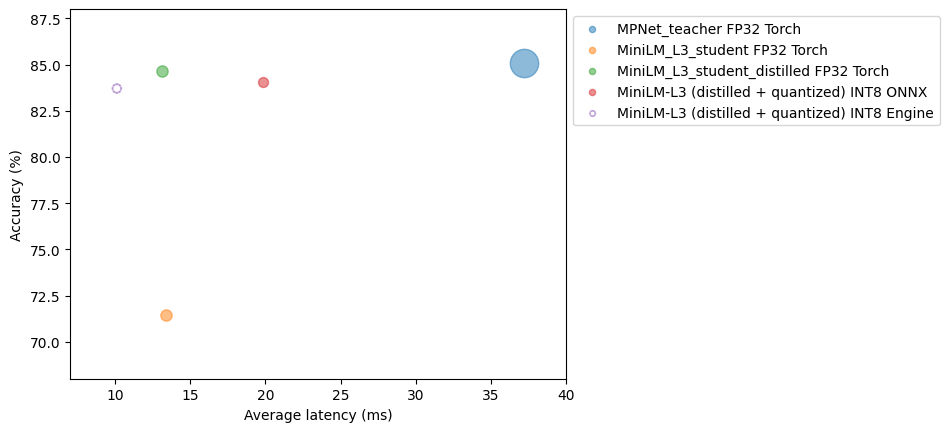

In [17]:
plot_metrics(perf_metrics, optim_type)

In [18]:
print('\n'.join(["{}: {:.2f}%, {:.2f}ms, {:.2f}MB".format(k, perf_metrics[k]['accuracy']*100, perf_metrics[k]['time_avg_ms'], perf_metrics[k]['size_mb']) for k in perf_metrics]))

MPNet_teacher FP32 Torch: 85.07%, 37.20ms, 417.73MB
MiniLM_L3_student FP32 Torch: 71.47%, 13.38ms, 66.36MB
MiniLM_L3_student_distilled FP32 Torch: 84.64%, 13.13ms, 66.36MB
MiniLM-L3 (distilled + quantized) INT8 ONNX: 84.04%, 19.87ms, 51.33MB
MiniLM-L3 (distilled + quantized) INT8 Engine: 83.72%, 10.04ms, 50.67MB


## SetFit Model Usage

In [19]:
example_sentence = "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
predicted_label = setfit_engine_model(example_sentence)
print(f"Given sentence:\n  {example_sentence}")
print(f"Model's prediction on this sentence is:\n  {topics.int2str(predicted_label)[0]}")

Given sentence:
  Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Model's prediction on this sentence is:
  Business
